# import and detail
گرفتن اطلاعات از دیتا ها و ایمپرت کتاب خانه های مورد نظر

In [ ]:
import pandas as pd
from google.colab import files

# آپلود فایل‌ها
uploaded = files.upload()

# لود داده‌ها
dfs_new = {}
for filename in uploaded.keys():
    df = pd.read_excel(filename, parse_dates=True)
    dfs_new[filename] = df
    print(f"✅ {filename} لود شد")
    print(df.head(), "\n")
    print(df.info(), "\n")
    print(df.describe(), "\n")


Saving urea daily 2017.xlsx to urea daily 2017.xlsx
Saving urea weekly 2017 (1).xlsx to urea weekly 2017 (1).xlsx
✅ urea daily 2017.xlsx لود شد
        Date  Price   Open   High    Low Vol.  Change %
0 2025-09-15  427.5  427.5  427.5  427.5  NaN    0.0000
1 2025-09-12  427.5  427.5  427.5  427.5  NaN    0.0000
2 2025-09-11  427.5  427.5  427.5  427.5  NaN   -0.0023
3 2025-09-10  428.5  428.5  428.5  428.5  NaN   -0.0058
4 2025-09-09  431.0  431.0  431.0  431.0  NaN    0.0117 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1986 non-null   datetime64[ns]
 1   Price     1986 non-null   float64       
 2   Open      1986 non-null   float64       
 3   High      1986 non-null   float64       
 4   Low       1986 non-null   float64       
 5   Vol.      106 non-null    object        
 6   Change %  1986 non-null   float64      

# preprocessing

در این مرحله دیتا آماده شد، ستون Vol. حذف شد چون داده ناکافی داشت، و lag feature ها برای پیش‌بینی قیمت اوره در هفته‌های بعد ساخته شد. سپس دیتا به بخش‌های آموزش و تست تقسیم شد تا مدل‌ها روی آن آموزش و ارزیابی شوند

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# انتخاب یکی از دیتاست‌ها (روزانه یا هفتگی)
df = dfs_new['urea daily 2017.xlsx'].copy()  # یا 'urea weekly 2017 (1).xlsx'

# حذف ستون Vol.
if 'Vol.' in df.columns:
    df = df.drop(columns=['Vol.'])

# مرتب‌سازی بر اساس تاریخ (قدیمی به جدید)
df = df.sort_values('Date').reset_index(drop=True)

# ساخت lag features
lags = [1, 2, 3]  # می‌تونی تعداد lag ها رو بیشتر هم کنی
for lag in lags:
    df[f'Price_lag_{lag}'] = df['Price'].shift(lag)
    df[f'Change %_lag_{lag}'] = df['Change %'].shift(lag)

# حذف ردیف‌های با مقادیر NaN (به دلیل lag)
df = df.dropna().reset_index(drop=True)

# تعریف X و y
feature_cols = [col for col in df.columns if 'lag' in col]
X = df[feature_cols]
y = df['Price']  # تارگت = قیمت اوره

# تقسیم train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # shuffle=False چون داده سری زمانی هست
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1586, 6)
Shape of X_test: (397, 6)
Shape of y_train: (1586,)
Shape of y_test: (397,)


# آماده‌سازی دیتا برای LSTM
LSTM با سری زمانی بهتر کار می‌کنه، پس باید داده‌ها رو reshape کنیم:

In [3]:
import numpy as np

# تبدیل X به آرایه numpy
X_train_np = X_train.values
X_test_np = X_test.values

# reshape برای LSTM: [samples, time_steps, features]
# چون ما lag ها رو داریم، time_steps = تعداد lag ها = 3
# و features = تعداد ستون‌ها تقسیم بر lag ها
n_lags = 3
n_features = X_train_np.shape[1] // n_lags

X_train_lstm = X_train_np.reshape((X_train_np.shape[0], n_lags, n_features))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], n_lags, n_features))

print("Shape for LSTM:")
print("X_train_lstm:", X_train_lstm.shape)
print("X_test_lstm:", X_test_lstm.shape)


Shape for LSTM:
X_train_lstm: (1586, 3, 2)
X_test_lstm: (397, 3, 2)


# تعریف مدل LSTM

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# مدل LSTM ساده
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))  # خروجی قیمت اوره
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# آموزش مدل
history = model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 217923.6406 - val_loss: 53141.6602
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22514.7617 - val_loss: 118.1423
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 172.3985 - val_loss: 117.5707
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 137.1262 - val_loss: 118.5421
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 172.7586 - val_loss: 171.7588
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 214.0052 - val_loss: 120.5466
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 237.9304 - val_loss: 107.4633
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119.6898 - val_loss: 119.5277
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 212.9326 - val_loss: 117.0721
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 168.5818 - val_loss: 112.0766
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 179.0154 - val_loss: 121.0093
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━

# پیش‌بینی و آماده‌سازی Gradient Boosting

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

# پیش‌بینی LSTM روی کل دیتا
lstm_pred_train = model_lstm.predict(X_train_lstm).flatten()
lstm_pred_test = model_lstm.predict(X_test_lstm).flatten()

# اضافه کردن خروجی LSTM به عنوان ویژگی جدید برای GB
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()
X_train_gb['LSTM_pred'] = lstm_pred_train
X_test_gb['LSTM_pred'] = lstm_pred_test

# مدل Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
gb_model.fit(X_train_gb, y_train)

# پیش‌بینی
y_pred = gb_model.predict(X_test_gb)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# ارزیابی دقت مدل

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f}")


R2 Score: 97.63%
Mean Absolute Error: 4.28


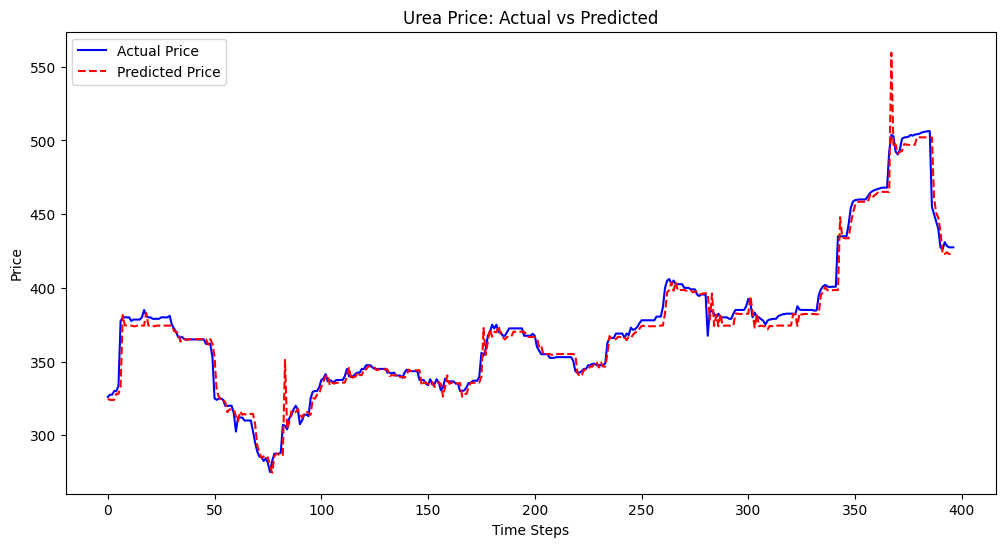

In [7]:
import matplotlib.pyplot as plt

# فرض کنیم y_test و y_pred داریم
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red', linestyle='--')
plt.title('Urea Price: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


# انتخاب بازه برای zoom

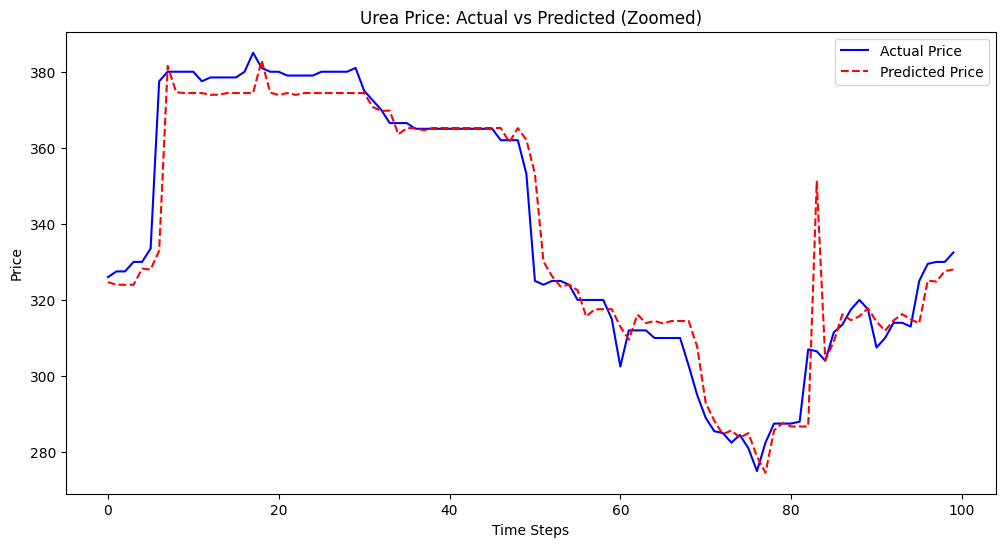

In [9]:
start, end = 0, 100  # می‌تونی تغییر بدی
plt.figure(figsize=(12,6))
plt.plot(y_test.values[start:end], label='Actual Price', color='blue')
plt.plot(y_pred[start:end], label='Predicted Price', color='red', linestyle='--')
plt.title('Urea Price: Actual vs Predicted (Zoomed)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# تحلیل خطای پیش‌بینی

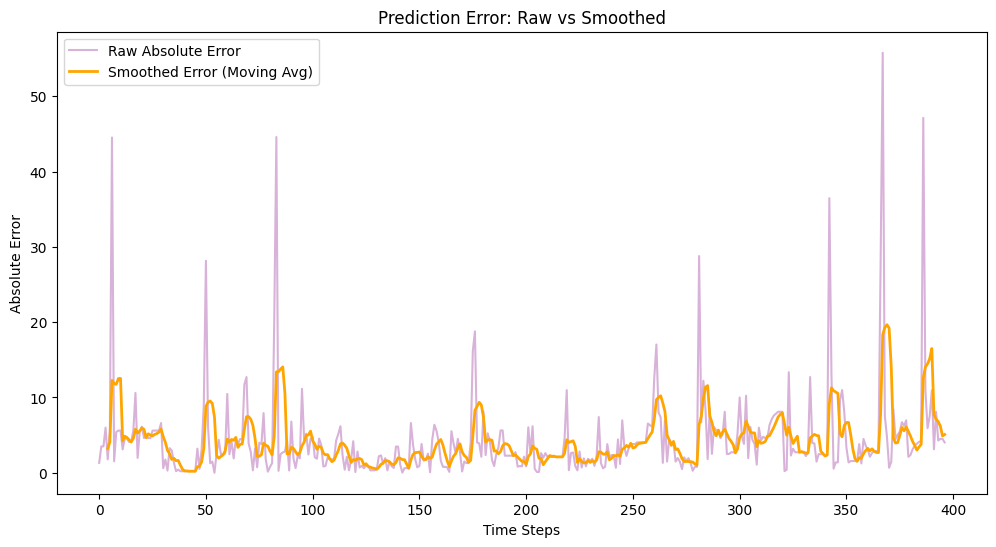

In [11]:
import pandas as pd

errors = abs(y_test.values - y_pred)
errors_smooth = pd.Series(errors).rolling(window=5).mean()  # میانگین متحرک 5 مرحله‌ای

plt.figure(figsize=(12,6))
plt.plot(errors, label='Raw Absolute Error', color='purple', alpha=0.3)
plt.plot(errors_smooth, label='Smoothed Error (Moving Avg)', color='orange', linewidth=2)
plt.title('Prediction Error: Raw vs Smoothed')
plt.xlabel('Time Steps')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()


# برای دانلود دیتاست نهایی

In [8]:
from google.colab import files

df.to_excel("urea_processed.xlsx", index=False)
files.download("urea_processed.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>